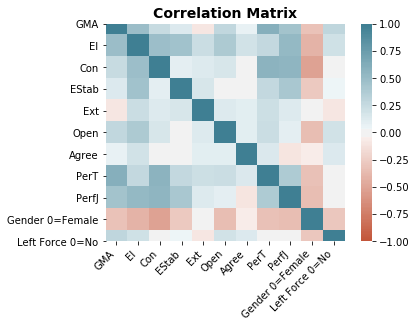

In [1]:
#Reference/Code: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as stats
%matplotlib inline

data = pd.read_csv('./PoliceDataFull2021.csv')
#print ("data:", data)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.title("Correlation Matrix", fontsize="14", fontweight="bold")

plt.show()


In [2]:
# Reference: Copied and modified from-
# https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot


In [3]:
def setupformat(x, ax, plt, title, xlabel, ylabel):
    # Figure Modifications --------------------------------------------------------
    # Borders
    ax.spines["top"].set_color("0.5")
    ax.spines["bottom"].set_color("0.5")
    ax.spines["left"].set_color("0.5")
    ax.spines["right"].set_color("0.5")
    ax.get_xaxis().set_tick_params(direction="out")
    ax.get_yaxis().set_tick_params(direction="out")
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left() 

    # Labels
    plt.title(title, fontsize="14", fontweight="bold")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(np.min(x) - 1, np.max(x) + 1)

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    display = (0, 1)
    anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
    legend = plt.legend(
        [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
        [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
        loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
    )  
    frame = legend.get_frame().set_edgecolor("0.5")

    # Save Figure
    plt.tight_layout()
    #plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")
    #plt.show()

In [4]:
def poststats(x, y, ax, plt):

    #print ("DEBUG x.shape:", x.shape, "y.shape:", y.shape)
    slope, intercept = np.polyfit(np.array(x), np.array(y), 1)  # linear model adjustment

    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

    residual = y - y_model

    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # calculating the r2
    # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
    # Pearson's correlation coefficient
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2

    # mean squared error
    MSE = 1/n * np.sum( (y - y_model)**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = np.polyval([slope, intercept], x_line)

    # confidence interval
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    # predicting interval
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

    # rounding and position must be changed for each case and preference
    a = str(np.round(intercept))
    b = str(np.round(slope,2))
    r2s = str(np.round(r2,2))
    MSEs = str(np.round(MSE))

    ax.text(min(x), max(y), 'y = ' + a + ' + ' + b + ' x' + '\n' + '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
    #plt.legend(loc='upper right', bbox_to_anchor=(1, .25), fontsize=12)


In [5]:
def plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")
    setupformat(x, ax, plt, title, xlabel, ylabel)
    poststats(x, y,ax,plt)
    return ax

In [6]:
# Computations ----------------------------------------------------------------    

def plot(x, y, title, xlabel, ylabel):
    # Modeling with Numpy
    def equation(a, b):
        """Return a 1D polynomial."""
        return np.polyval(a, b) 

    p, cov = np.polyfit(np.array(x), np.array(y), 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = x.size                                                 # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    # Data
    ax.plot(
        x, y, "o", color="#b9cfe7", markersize=8, 
        markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
    )

    # Fit
    ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")

    # Confidence Interval (select one)
    plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=ax)
    #plot_ci_bootstrap(x, y, resid, ax=ax)

    plt.show()

In [7]:
# Actually plotting real police data!!

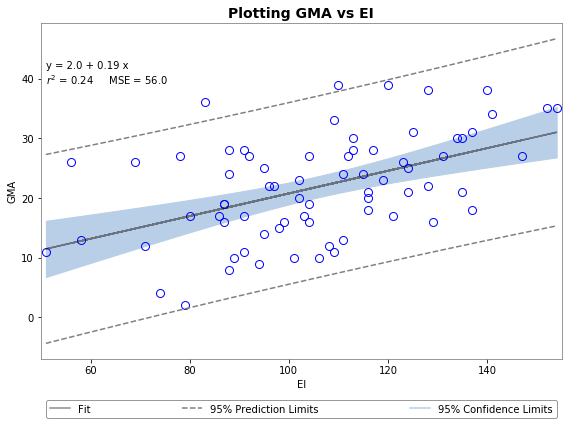

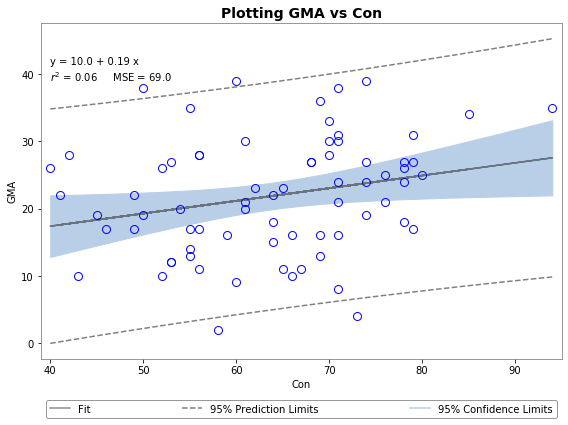

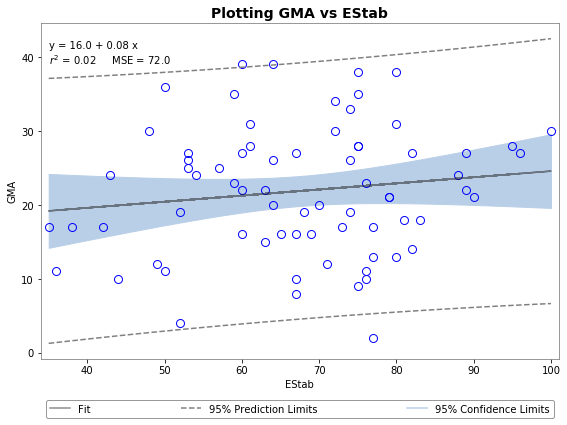

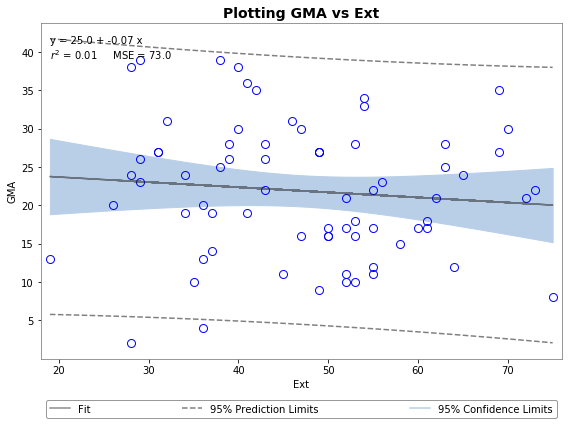

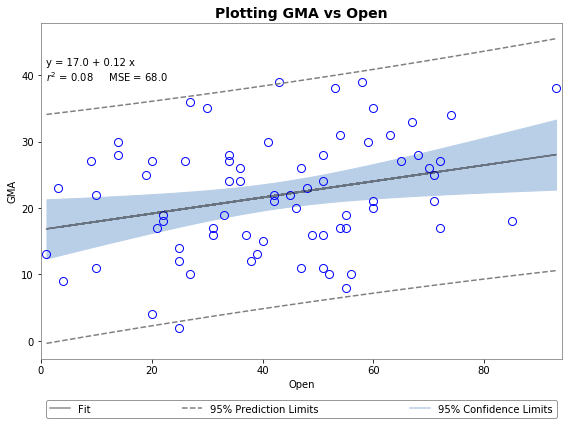

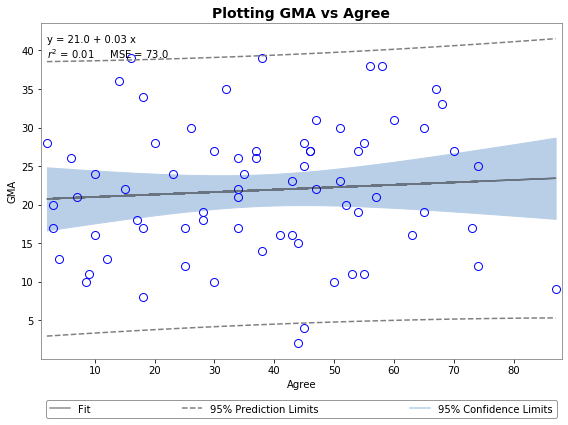

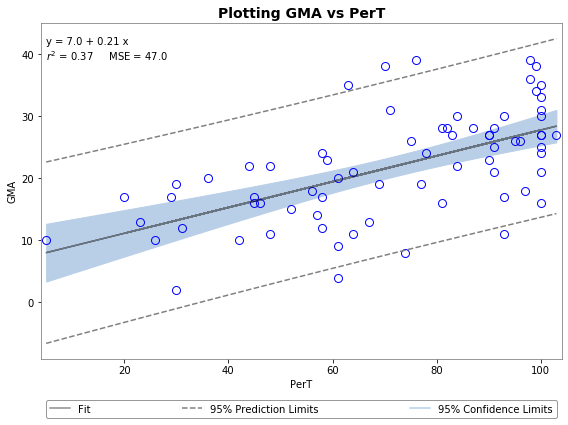

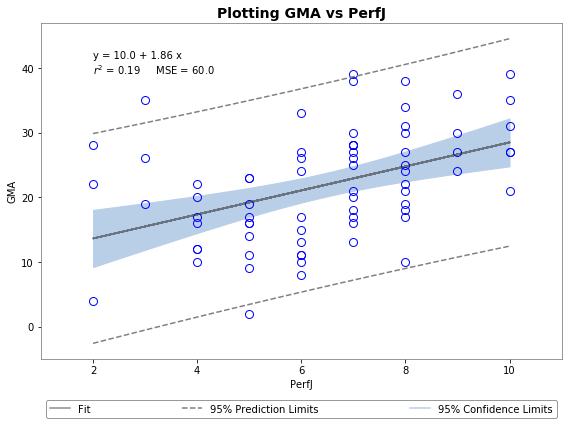

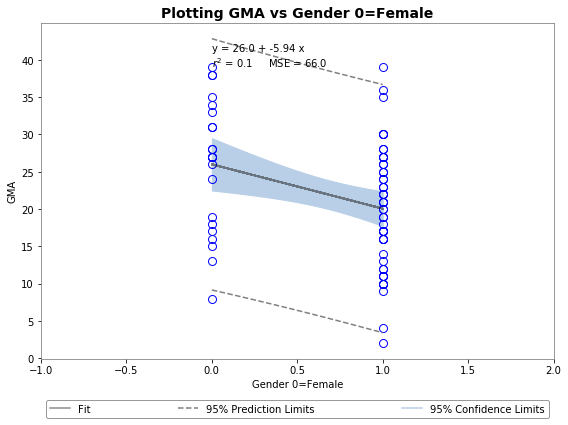

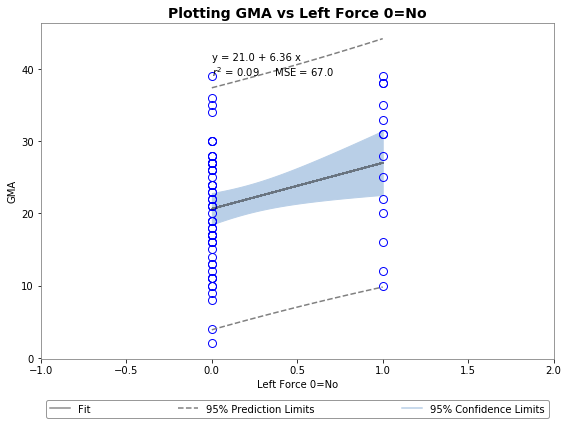

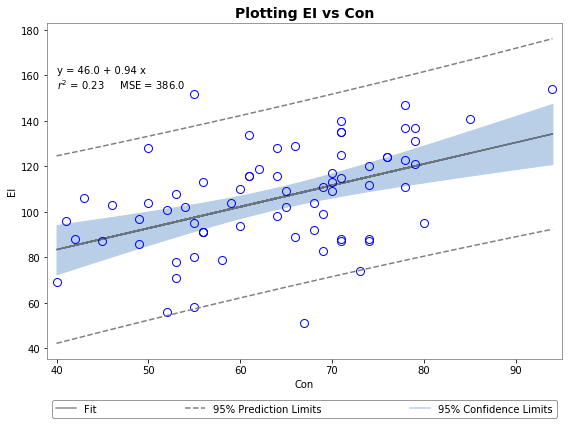

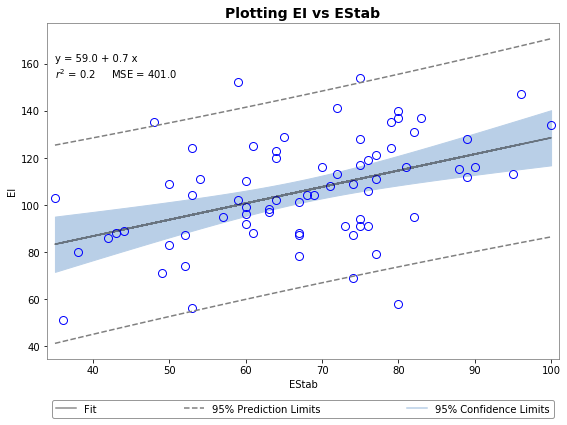

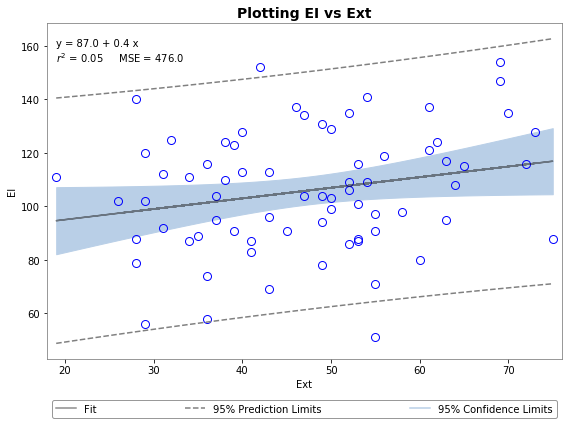

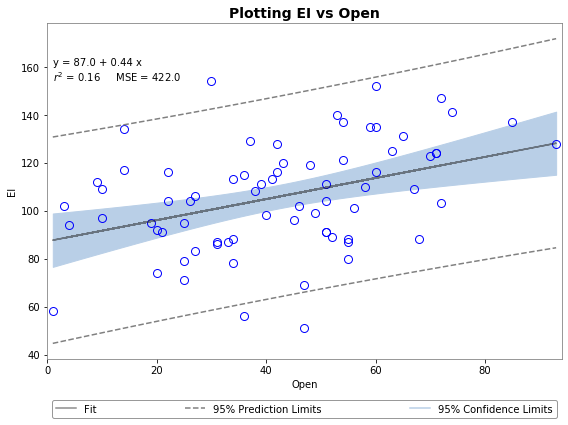

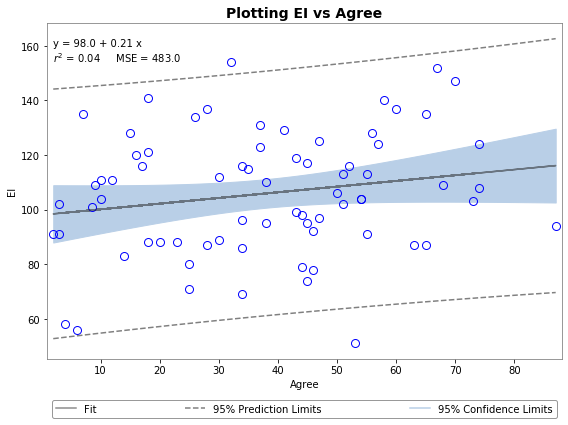

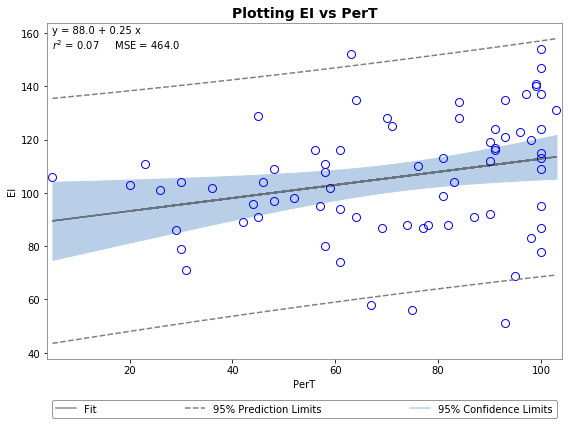

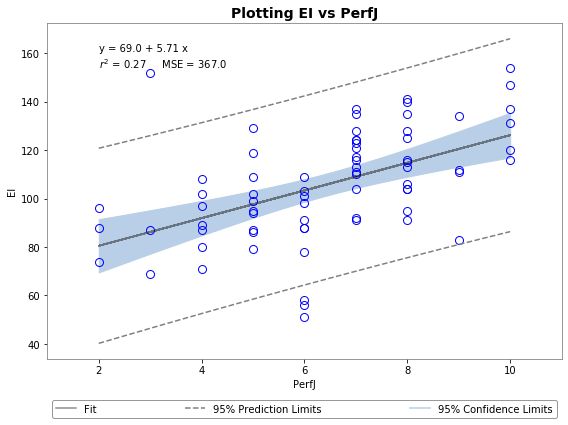

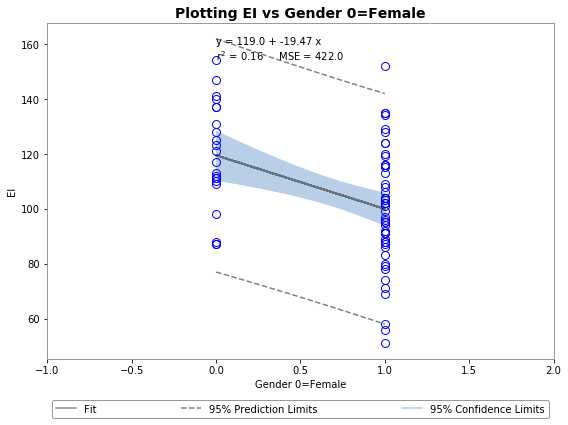

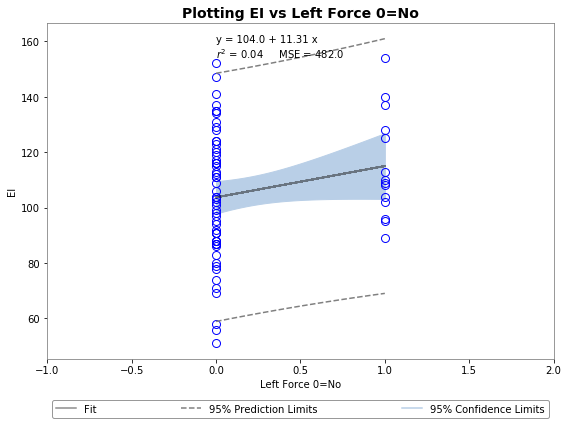

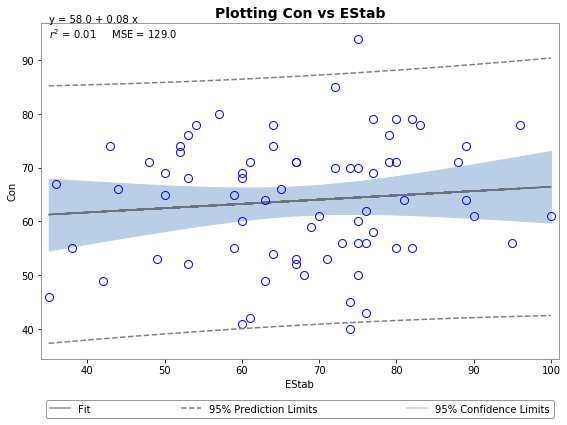

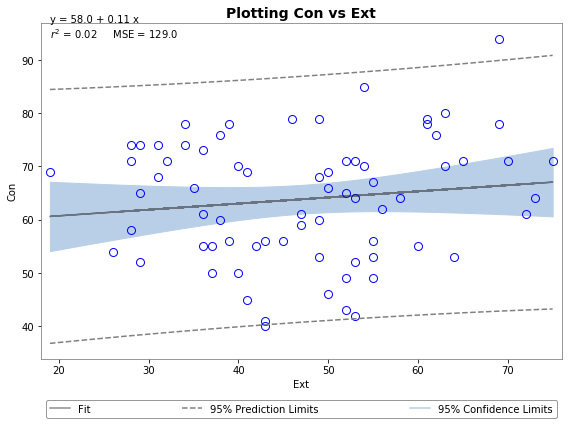

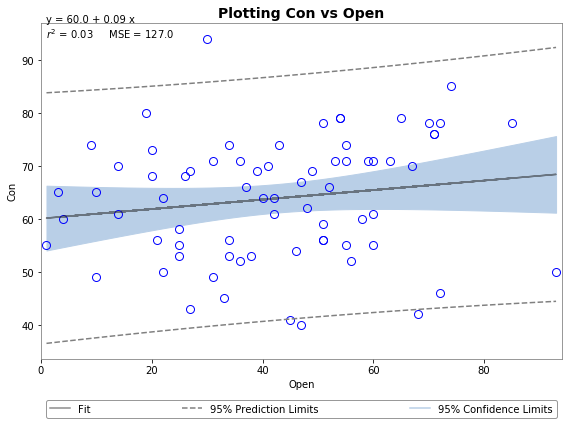

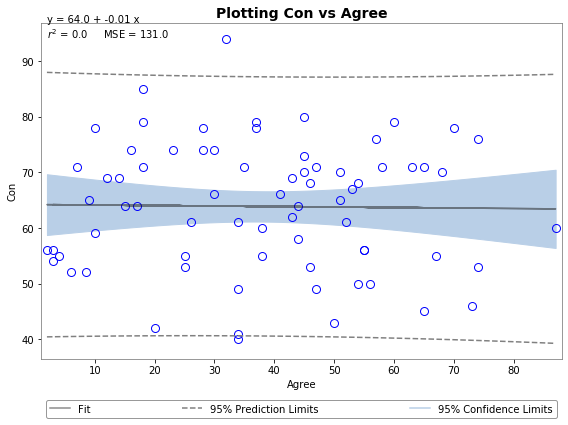

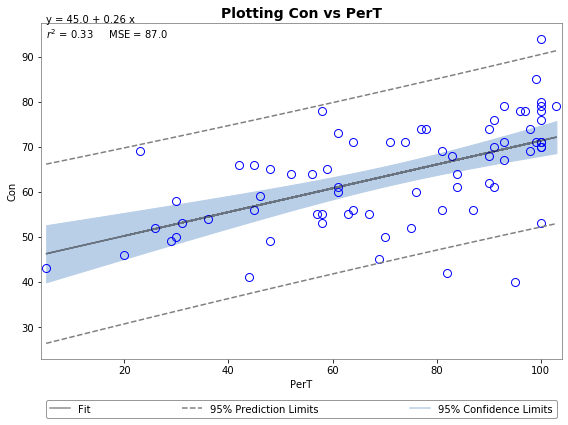

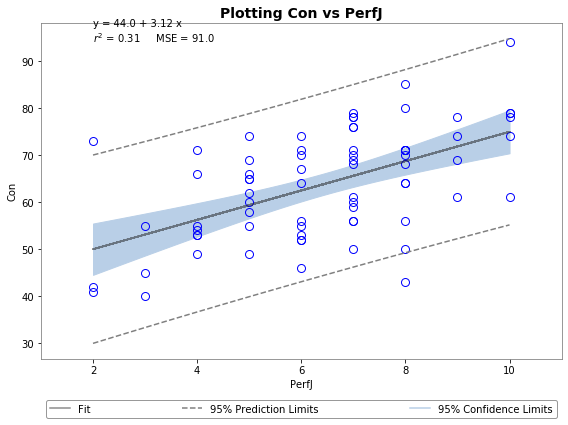

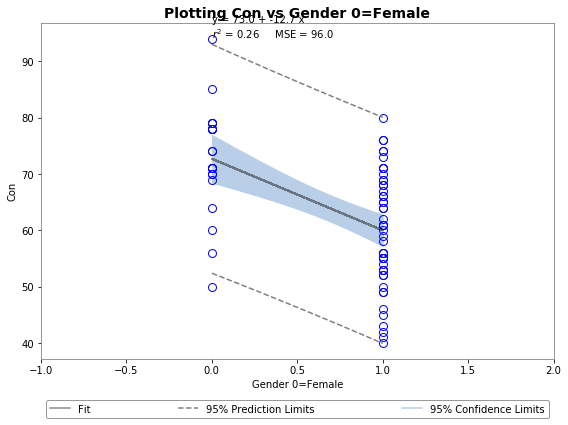

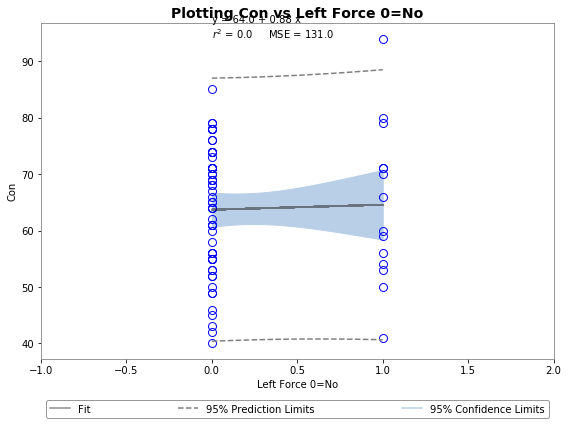

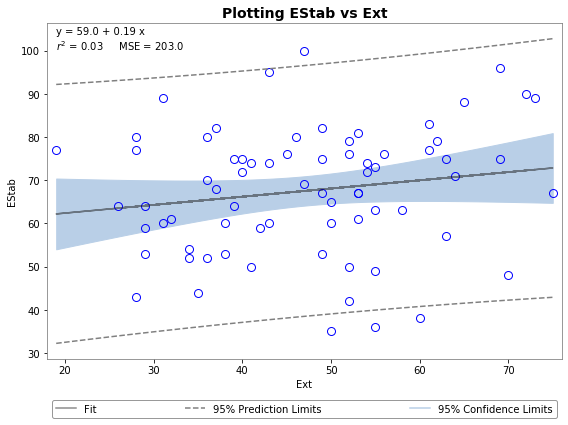

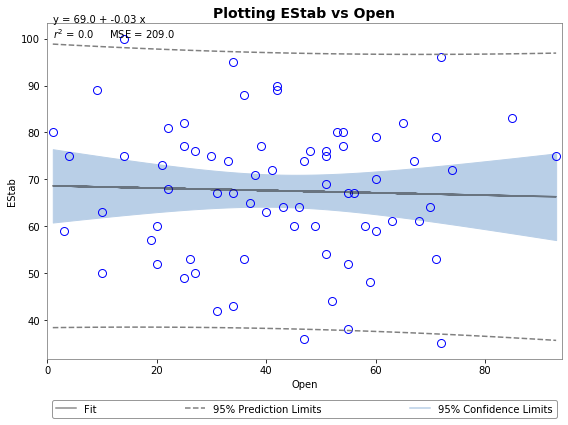

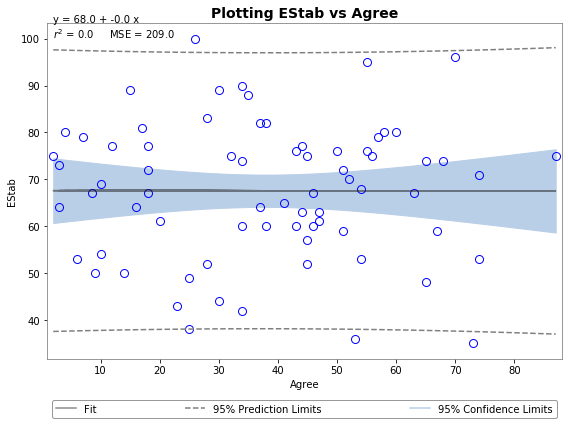

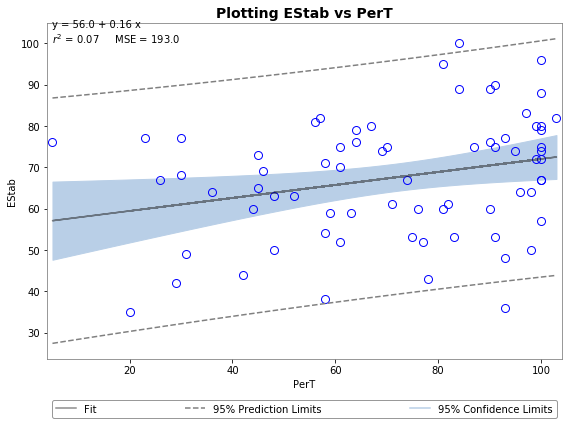

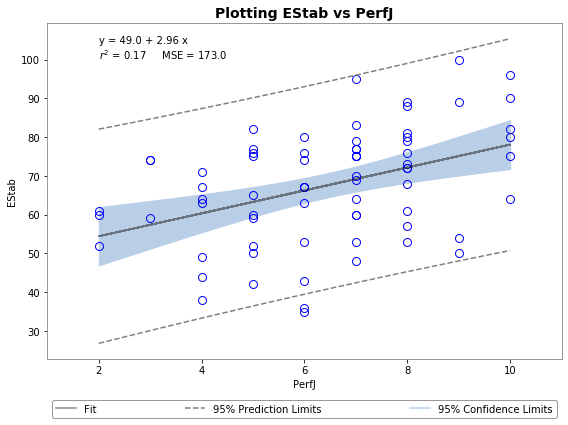

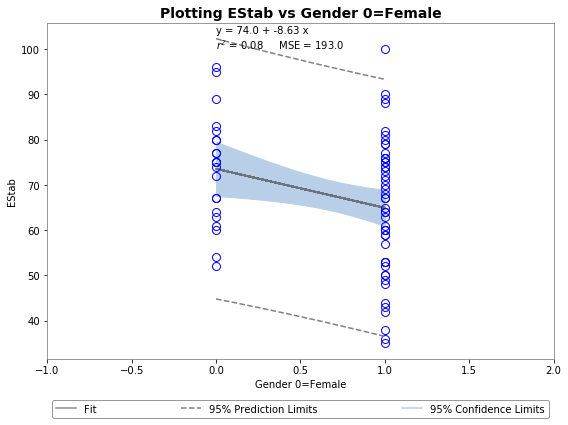

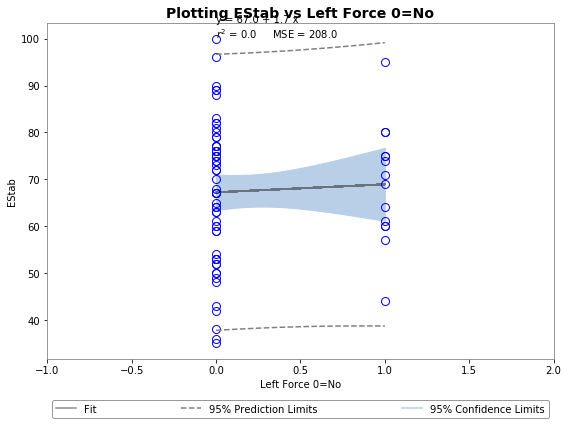

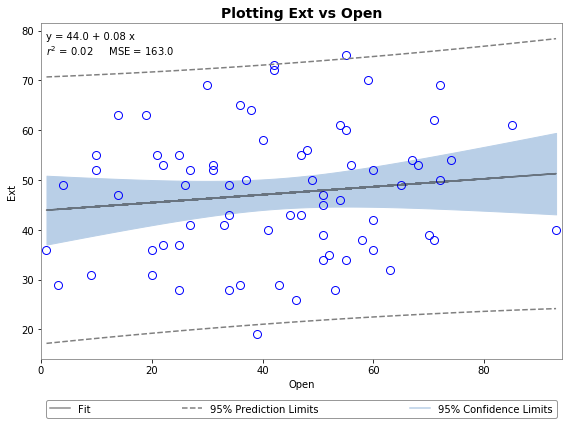

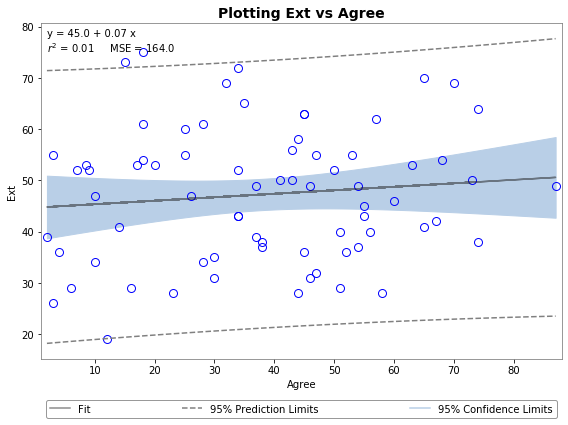

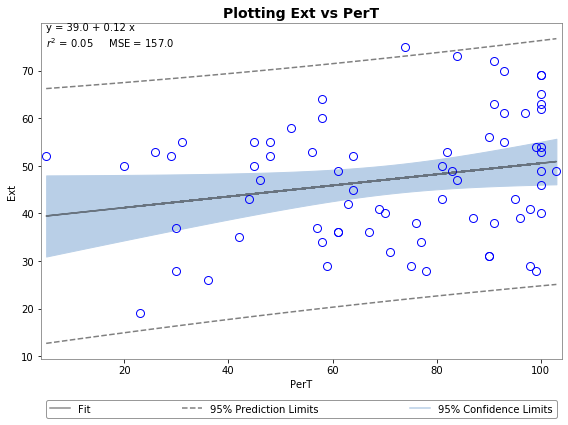

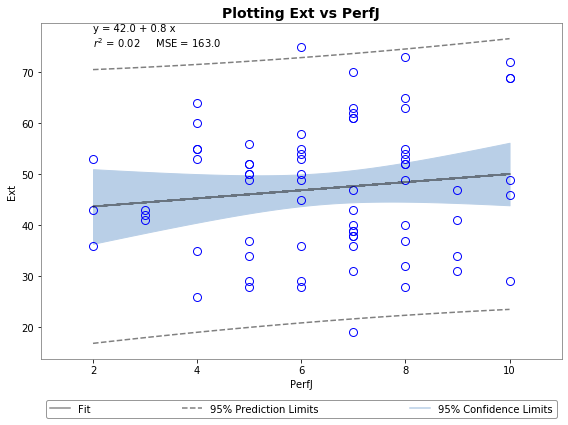

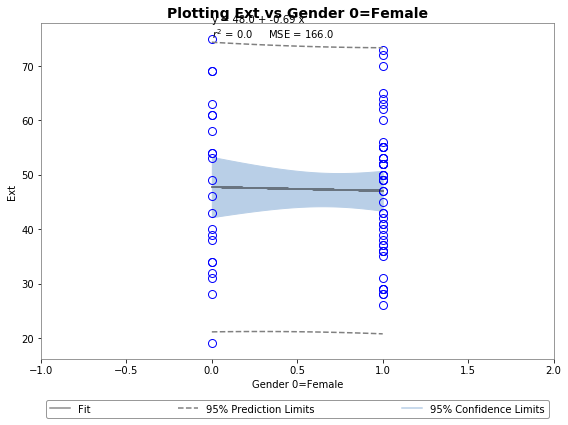

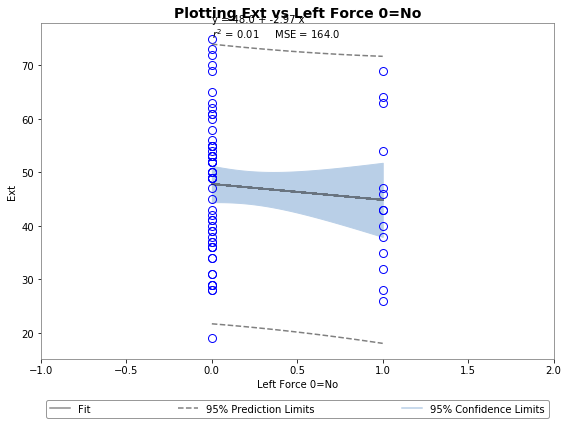

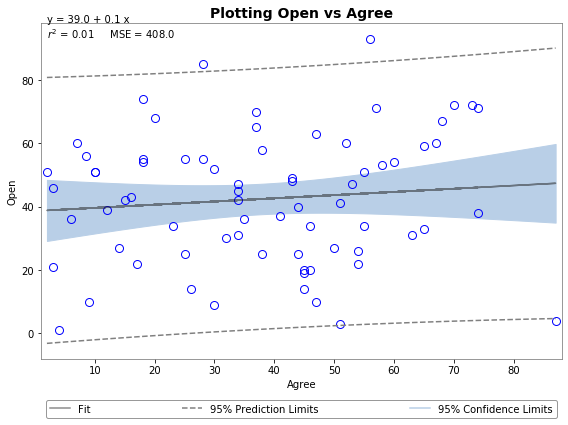

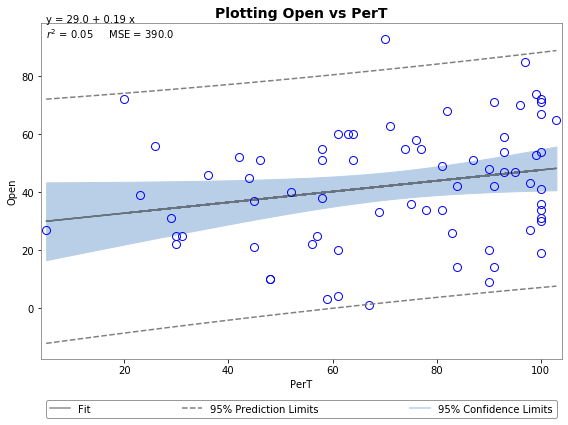

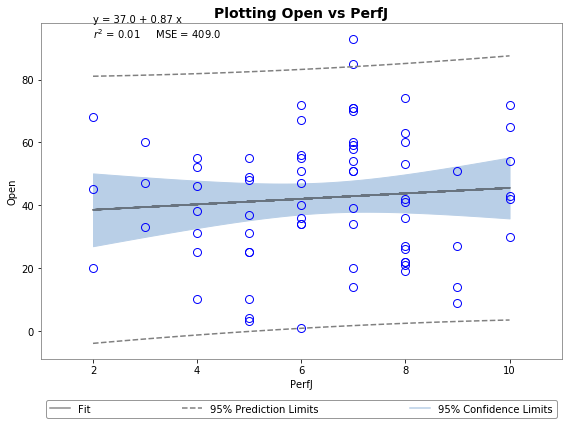

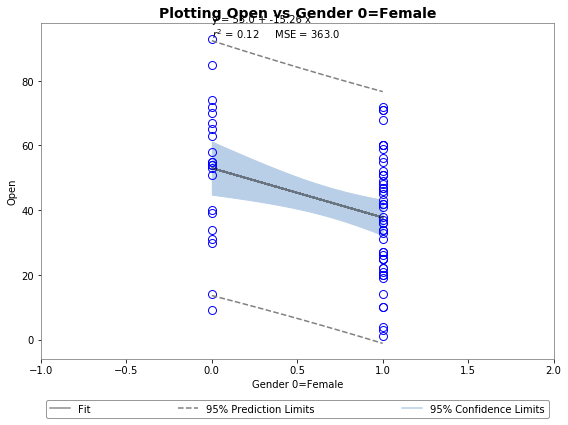

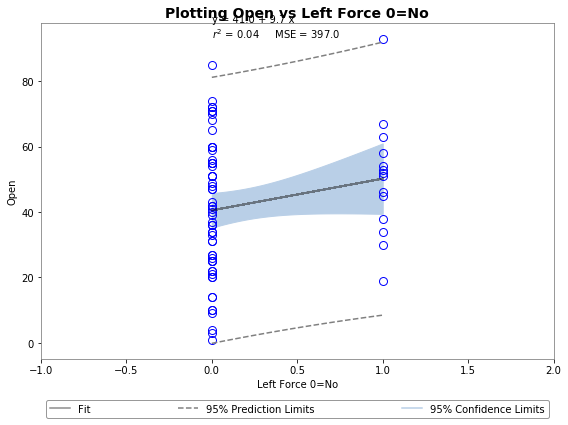

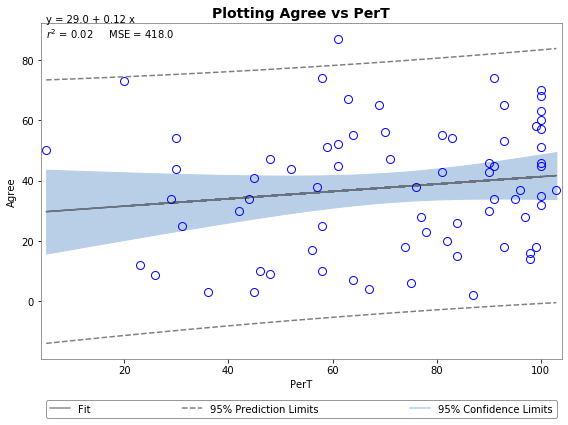

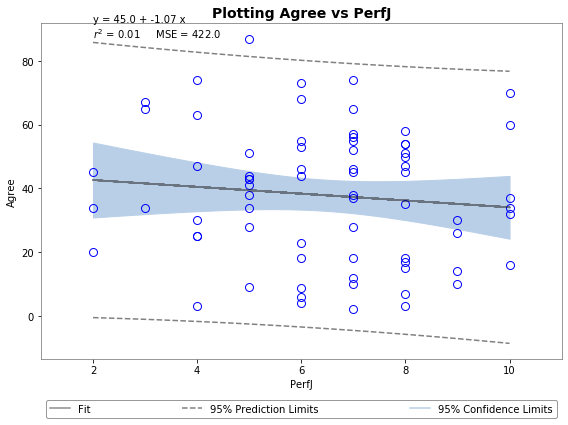

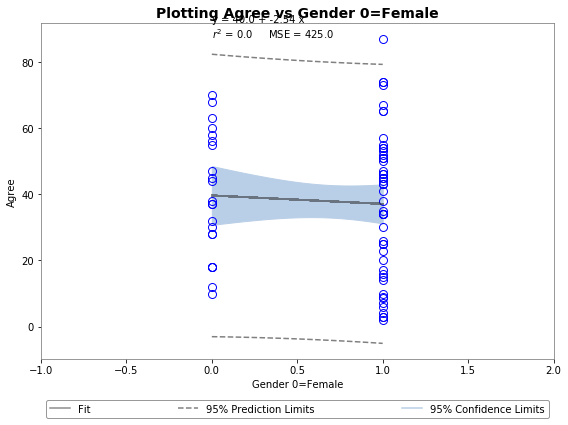

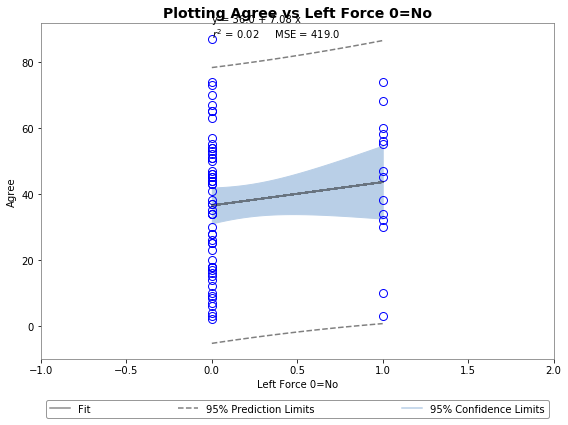

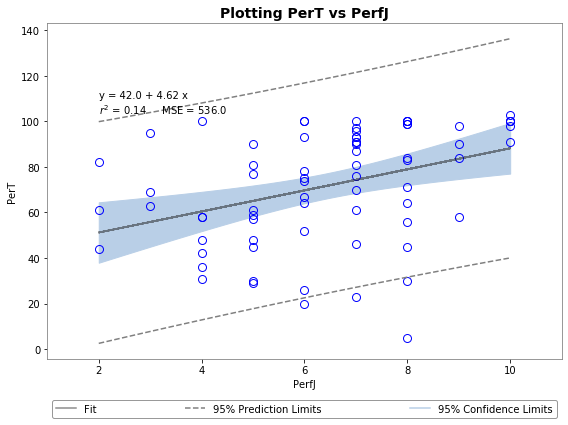

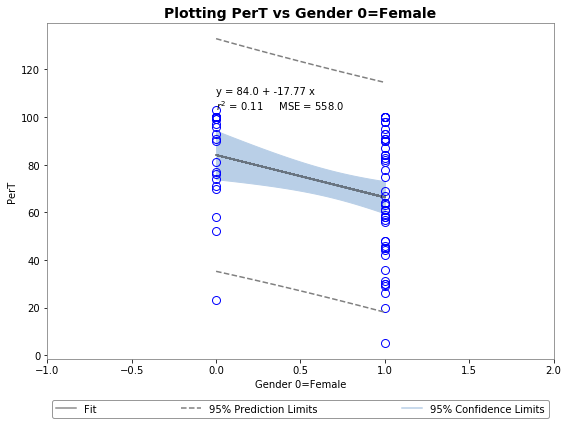

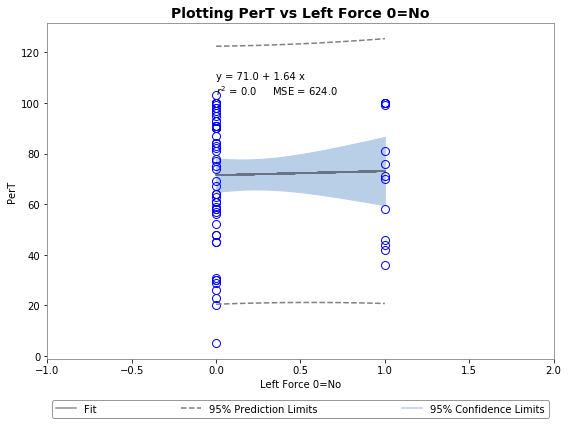

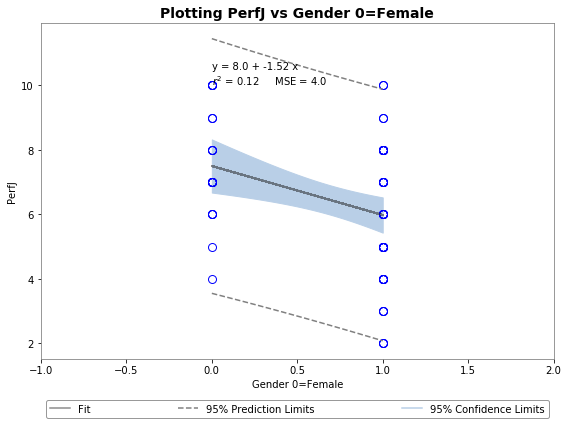

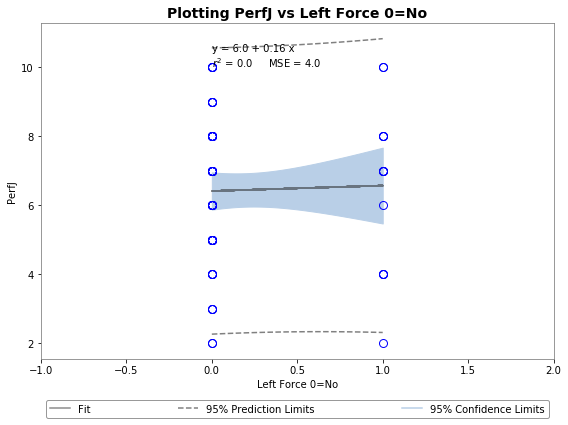

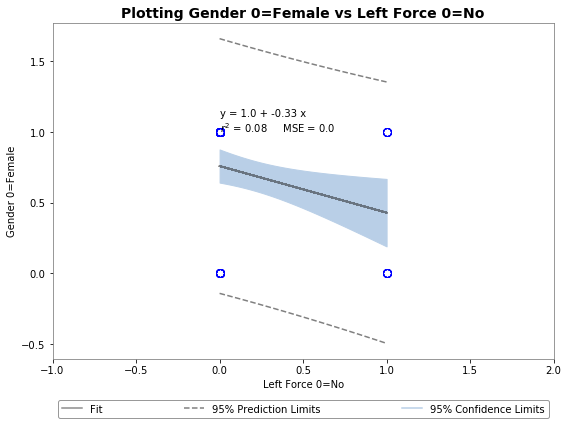

Total  55 combinations


In [8]:
def plotcombinations(data):
    columns = data.columns
    tot = 0
    for i, ylabel in enumerate(columns):
        for j in range(i+1, len(columns)):
            #Hacky, but put x-axis as later values so gender and left force only appears on x-axis
            xlabel = columns[j]
            title = "Plotting " + ylabel + " vs " + xlabel
            plot(np.ravel(data[xlabel]), np.ravel(data[ylabel]), title, xlabel, ylabel)
            tot += 1
    print ("Total ", tot, "combinations")
plotcombinations(data)

In [9]:
#Function to plot a selected piece of data
def plotone(data, xlabel, ylabel):
    columns = data.columns
    title = "Plotting " + ylabel + " vs " + xlabel
    plot(np.ravel(data[xlabel]), np.ravel(data[ylabel]), title, xlabel, ylabel)
#plotone(data)